---
title: "Pardeamiento del raquis de uva de mesa"
format:
  html:
    code-fold: true        # hace que cada bloque sea colapsable
    code.tools: true
    code-summary: "▶ CODE" # texto que aparece sobre el código
    toc: true              # (opcional) agrega tabla de contenido
    theme: cosmo           # (opcional) estilo visual
---



## Hipotesis 
La sensibilidad del raquis a la deshidratación en poscosecha estaría determinada por características presentes al momento de la cosecha, por lo que es posible diagnosticar dicha sensibilidad mediante indicadores específicos del tejido.


## Objetivo 
Determinar la sensibilidad del raquis de uva de mesa a la deshidratación en poscosecha a través de los cambios que ocurren en el color y contenido de agua de este tejido durante la cosecha.


In [1]:

# Import librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

## Resultados

### 1. Caracterizacion inicial a cosecha 

In [2]:
print('Tabla 1: Caracterizacion inicial en cosecha, cv. Allison y S. Celebretion.(media - DE)')

datos_inicial = pd.read_excel('datos/caracterizacion inicial.xlsx')
df = pd.DataFrame(datos_inicial)
df.columns = df.columns.str.strip() # Normalizar nombres de columnas 

# Filtro de datos de acuerdo evaluacion 0h,3h,18h 
df_filtrado = df[df["Evaluacion"].isin(["E00", "E03", "E18"])]

# Tabla resumen de caracterizacion inicial 
df_resumen =(df_filtrado.groupby('Variedad')[['TSS','Acidez_titulable', 'Peso', 'Calibre_Ecuatorial', 'Firmeza']] 
.agg(['mean', 'std','count']) 
.round(2) 
.reset_index() 
) 
# creamos un tabal media + DE
tabla_resumen = pd.DataFrame()
tabla_resumen["Variedad"] = df_resumen["Variedad"]

for var in ["TSS", "Acidez_titulable", "Peso", "Calibre_Ecuatorial", "Firmeza"]:
    tabla_resumen[var] = df_resumen.apply(
        lambda x: f"{x[(var, 'mean')]:.2f} ± {x[(var, 'std')]:.2f}", axis=1
    )

tabla_resumen


Tabla 1: Caracterizacion inicial en cosecha, cv. Allison y S. Celebretion.(media - DE)


,Variedad,TSS,Acidez_titulable,Peso,Calibre_Ecuatorial,Firmeza
0,AL,19.04 ± 1.04,0.64 ± 0.07,10.18 ± 1.82,22.57 ± 1.58,322.48 ± 64.59
1,SC,18.04 ± 0.80,0.78 ± 0.09,9.03 ± 1.61,23.60 ± 1.54,242.69 ± 18.44


### 2. Correlaciones de acuedo hue inicial, Contenido Relativo del agua y pardeamiento
 Se correlacionan de auerdo cada variedad con caracterizacion inicial, de hue en promedio de cada raquis con la finalidad de predecir el pardeamiento del rauis de uva de mesa, y predecir desde el campo muy templano en pardeamiento mejorando asi el almacenamiento en poscosecha. si la  @fig-cra-pardo hhehe

In [3]:
#| label: fig-cra-pardo
#| fig-cap: Correlación entre CRA y Pardeamiento
#Cargamos archivos de correlaciones 
datos_correlacion = pd.read_csv('datos/Pardeamiento uva de mesa.csv', sep= ';')
df = pd.DataFrame(datos_correlacion)
df.columns = df.columns.str.strip() # Normalizar nombres de columnas 

#Visualizar las primeras columnas de  df. 
#print(df.columns)
#df.info() 
#df.head()

# 1. Crear un identificador único por racimo
df['ID'] = (df['Variedad'].astype(str) + '_' +
            df['Productor'].astype(str) + '_' +
            df['Tratamientos'].astype(str) + '_' +
            df['Repeticion'].astype(str) + '_' +
            df['N_Racimo'].astype(str))

# 2. Pivotar para tener columnas separadas
tabla_correlaciones = (
    df.pivot_table(
        index=['Variedad', 'ID'],
        columns='Tiempo',
        values='Hue'
    )
    .reset_index()
    .round(2)  # redondear a 2 decimales
)

#Visualizar tabla de correlaciones
#tabla_correlaciones.head()
#tabla_correlaciones.info()


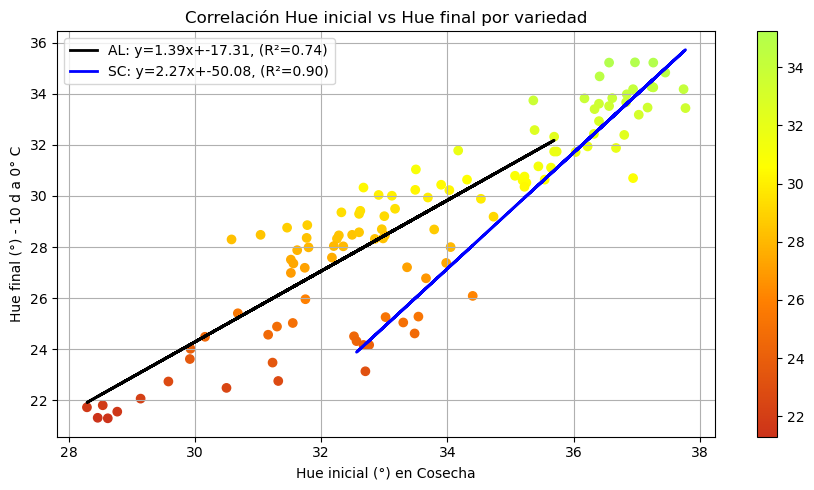

In [4]:
# Colormap personalizado (rojo degradado → naranja → amarillo → verde amarillento) con ayuda de Chatgpt
colors = [
    (0.8, 0.2, 0.1),   # Rojo degradado (menos saturado, más natural)
    (1.0, 0.5, 0.0),   # Naranja
    (1.0, 1.0, 0.0),   # Amarillo
    (0.7, 1.0, 0.3)    # Verde amarillento
]
cmap_rav = mcolors.LinearSegmentedColormap.from_list("rojo_amarillo_verde", colors, N=256) 


# Crear figura de correlaciones por variedad hus vs hue -----------------------------------------------------------------
plt.figure(figsize=(9, 5))
variedades = tabla_correlaciones['Variedad'].unique()

# Colores distintos para las líneas
colores_linea = ['black', 'blue']

# Correlaciones del T0 y T10
sc = plt.scatter(tabla_correlaciones['T0'],
                 tabla_correlaciones['T10'],
                 c=tabla_correlaciones['T10'], 
                 cmap=cmap_rav
)
# Regresión lineal por variedad
for i, variedad in enumerate(variedades):
    datos = tabla_correlaciones[tabla_correlaciones['Variedad'] == variedad]
    X = datos[['T0']].values
    y = datos['T10'].values
    
    #Regresion linel
    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)

    # Calcular R², pendiente, intercepto
    r2 = r2_score(y, y_pred)
    pendiente = modelo.coef_[0]
    intercepto = modelo.intercept_

    # Dibujar la línea de regresión variedad
    plt.plot(X, y_pred,
             color=colores_linea[i % len(colores_linea)],
             lw=2, label=f'{variedad}: y={pendiente:.2f}x+{intercepto:.2f}, (R²={r2:.2f})')

# Etiquetas y formato Grafico
plt.xlabel('Hue inicial (°) en Cosecha')
plt.ylabel('Hue final (°) - 10 d a 0° C')
plt.title('Correlación Hue inicial vs Hue final por variedad')
plt.colorbar()
plt.grid(True)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

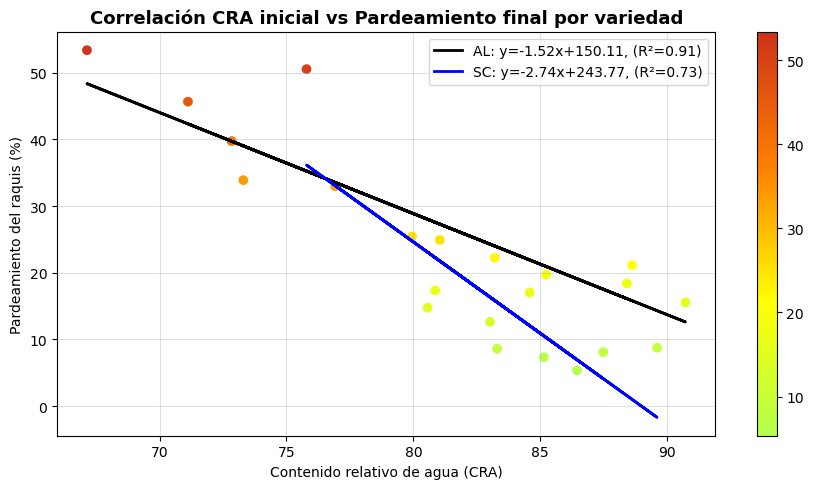

In [5]:
# 2  Correlacion de acuerdo CRA vs pardeamiento -----------------------------------------------------------------------
datos_CRA = pd.read_csv('datos/Contenido relativo de agua.csv', sep= ';')

#datos_CRA.info()

#Calculamos el promedio  CAR en T0
CRA_promedio_T0 = (
    datos_CRA
    .groupby(['Productor', 'Variedad', 'Color', 'Tratamientos'])['CAR']
    .mean()
    .round(2)
    .reset_index()
)

#Filtrar pardeamiento T10 ---
Pardo_t10 = df[df['Tiempo'] == 'T10']
#print(Pardo_t10.columns)

#Calculamso en promedio pardeamiento T10
Pardo_promedio_T10 = (
    Pardo_t10
    .groupby(['Productor', 'Variedad', 'Color', 'Tratamientos'])['Pardo']
    .mean()
    .round(2)
    .reset_index()
)
#Unimos ambos promedio por columnas comunes 
CAR_VS_PAR = pd.merge(
    CRA_promedio_T0,
    Pardo_promedio_T10, 
    on=['Productor','Variedad', 'Color','Tratamientos'] 
)
#visualizamos 
#CAR_VS_PAR.head()
#CAR_VS_PAR.info()

colors = [
    (0.7, 1.0, 0.3),   # Verde amarillento
    (1.0, 1.0, 0.0),   # Amarillo
    (1.0, 0.5, 0.0),   # Naranja
    (0.8, 0.2, 0.1)    # Pardo/rojo degradado
]
cmap_rav1 = mcolors.LinearSegmentedColormap.from_list("verde_a_pardo", colors, N=256)

# --- Crear gráfico de correlación CAR vs Pardo ---
plt.figure(figsize=(9, 5))
variedades = CAR_VS_PAR['Variedad'].unique()
colores_linea = ['black', 'blue']

# Dispersión global
sc = plt.scatter(CAR_VS_PAR['CAR'], CAR_VS_PAR['Pardo'], c=CAR_VS_PAR['Pardo'], cmap= cmap_rav1)

# Regresión lineal por variedad
for i, variedad in enumerate(variedades):
    datos = CAR_VS_PAR[CAR_VS_PAR['Variedad'] == variedad]
    X = datos[['CAR']].values
    y = datos['Pardo'].values
    
    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)
    
    r2 = r2_score(y, y_pred)
    pendiente = modelo.coef_[0]
    intercepto = modelo.intercept_
    
    plt.plot(X, y_pred,
             color=colores_linea[i % len(colores_linea)],
             lw=2,
             label=f'{variedad}: y={pendiente:.2f}x+{intercepto:.2f}, (R²={r2:.2f})')

# --- Formato final ---
plt.xlabel('Contenido relativo de agua (CRA)')
plt.ylabel('Pardeamiento del raquis (%)')
plt.title('Correlación CRA inicial vs Pardeamiento final por variedad', fontsize=13, weight='bold')
plt.colorbar()
plt.grid(alpha=0.4)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

### 3. Almacenamiento comercial en postcosecha. 

Revisara si las varibles de acuerdo el color en cosecha influyen en el pardeamiento del raquis de uva de mesa de amabas variedades. 

C:\Users\jhona\AppData\Local\Temp\ipykernel_41004\2086725063.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\jhona\AppData\Local\Temp\ipykernel_41004\2086725063.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


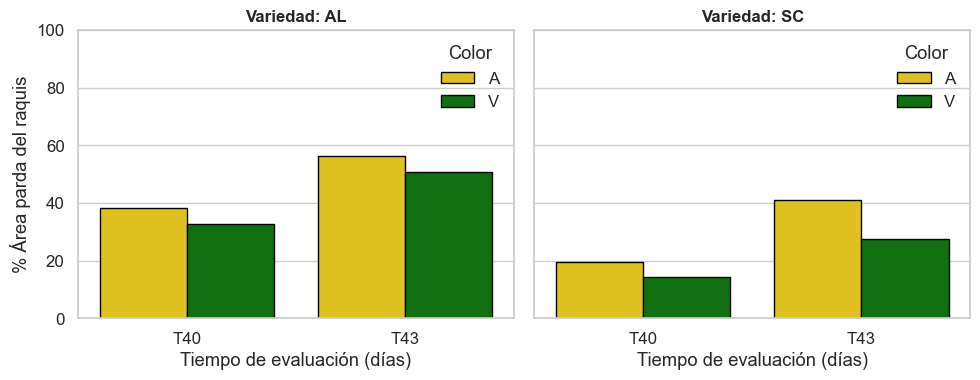

In [6]:
# Cargando datos de almacenamiento en poscosecha
datos = pd.read_csv('datos/Almacenamiento comercial.csv', sep= ';')
df_poscosecha = pd.DataFrame(datos)
df_poscosecha.columns = df_poscosecha.columns.str.strip()  #Eliminar espacio de los nombres de las columnas 

#visualizacion de datos 
#df_poscosecha.info()
#df_poscosecha.head()

# resumen de acuerdo variedad 
resumen2 = df_poscosecha.groupby(['Variedad','Tiempo', 'Color'])['Pardo'].agg(['mean', 'sem','max','min']).reset_index()
#print(resumen2)

# Estilo del gráfico
sns.set(style="whitegrid", font_scale=1.1)
colores = {'A': 'gold', 'V': 'green'}

# Crear dos gráficos (uno por variedad)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i, variedad in enumerate(resumen2['Variedad'].unique()):
    datos = resumen2[resumen2['Variedad'] == variedad]
    
    sns.barplot(
        data=datos,
        x='Tiempo',
        y='mean',
        hue='Color',
        palette=colores,
        ci=None,
        edgecolor='black',
        ax=axes[i]
    )
    
    axes[i].set_title(f"Variedad: {variedad}", fontsize=12, weight='bold')
    axes[i].set_xlabel("Tiempo de evaluación (días)")
    axes[i].set_ylabel("% Área parda del raquis" if i == 0 else "")
    axes[i].set_ylim(0, 100)
    axes[i].legend(title="Color", frameon=False)

plt.tight_layout()
plt.show()